In [76]:
import tensorflow as tf
import pandas as pd
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
#from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv('mbti_1.csv')
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [29]:
data.describe(include='O')

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq    1832                                                  1

In [30]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [32]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

### From above it is quite evident that there are many links in the text data. That needed to be removed.

In [33]:
# Stratify split to ensure equal distribution of data

train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

### Function to clean the text data.

In [34]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [35]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:03<00:00, 1980.92it/s]


In [36]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:00<00:00, 2038.42it/s]


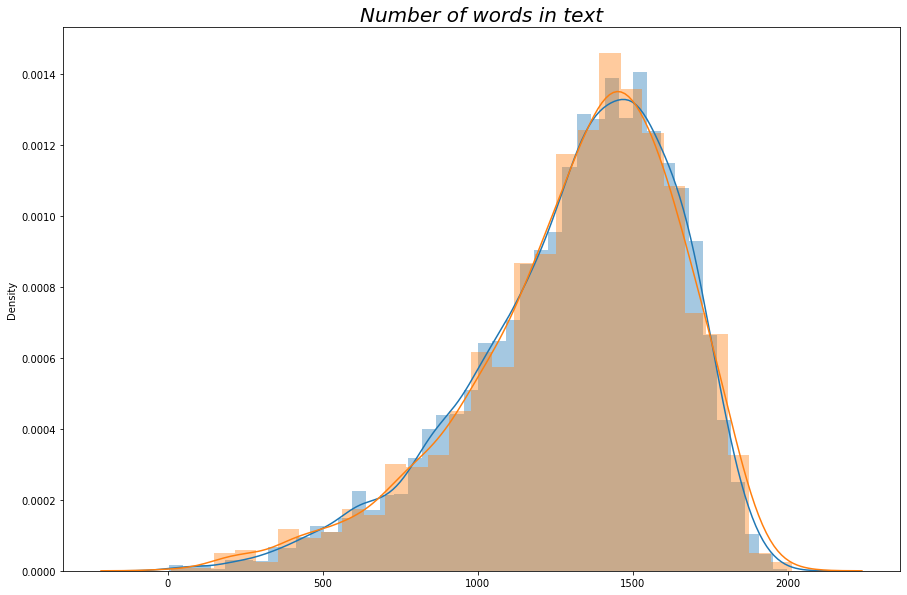

In [37]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [38]:

px.pie(train_data,names='type',title='Personality type',hole=0.3)


In [39]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

<h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Tokenizing words</h1>

In [40]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x00000234181A2EC8>)

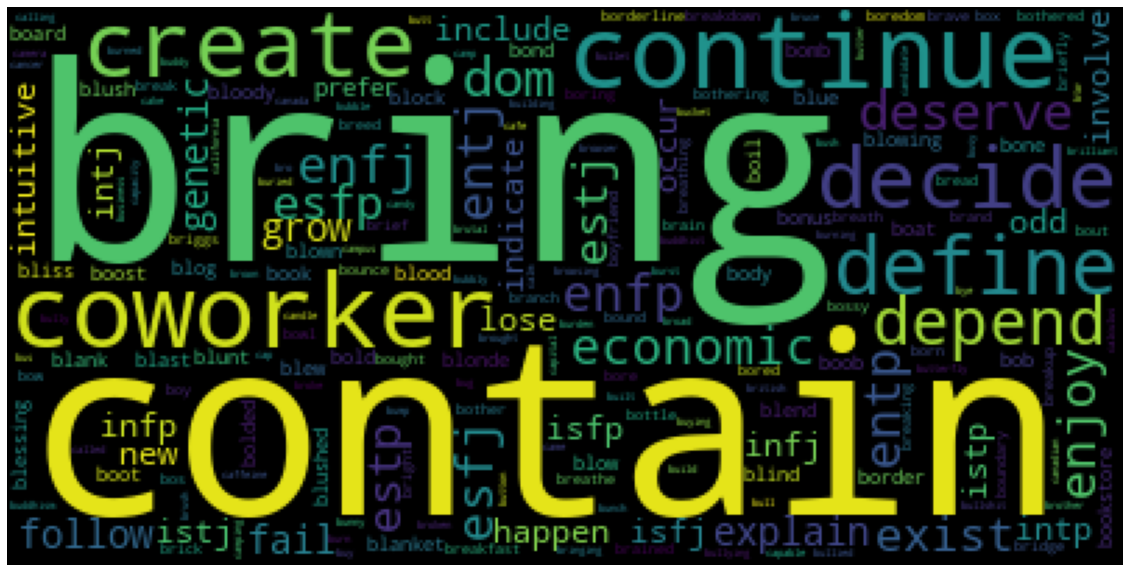

In [41]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [42]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [43]:
train_post.shape

(6940, 5000)

In [44]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

<h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Model selection</h1>

In [45]:
models_accuracy={}

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Logistic Regression</h4>

In [35]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [36]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.81      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.74      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1465
        INTJ       0.73      0.80      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.25      0.39       133
        ISFP       0.86      0.26      0.40       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.52      0.65       270

    accuracy                           0.72      

In [37]:
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.08      0.15        38
        ENFP       0.76      0.53      0.62       135
        ENTJ       0.75      0.13      0.22        46
        ENTP       0.66      0.51      0.58       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.64      0.71      0.67       294
        INFP       0.57      0.88      0.69       367
        INTJ       0.61      0.65      0.63       218
        INTP       0.67      0.83      0.74       261
        ISFJ       0.67      0.12      0.21        33
        ISFP       0.85      0.20      0.33        54
        ISTJ       0.60      0.07      0.13        41
        ISTP       0.68      0.45      0.54        67

    accuracy                           0.63      17

In [40]:
predolog=model_log.predict(test_post)

In [42]:
target_encoder.inverse_transform(predolog)

array(['INFP', 'INFP', 'INFJ', ..., 'INFJ', 'INFJ', 'ENTP'], dtype=object)

In [38]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Linear Support Vector classifier</h4>

In [ ]:
model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Support Vector classifier</h4>

In [ ]:
model_svc=SVC()
model_svc.fit(train_post,train_target)

In [ ]:

print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Multinomial Naive Bayes</h4>

In [ ]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

In [ ]:

print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Decision Tree Classifier</h4>

In [ ]:
model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

In [ ]:

print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Random Forest Classifier</h4>

In [ ]:
model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(train_post,train_target)

In [ ]:

print('train classification report \n ',classification_report(train_target,model_forest.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_forest.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['Random Forest Classifier']=accuracy_score(test_target,model_forest.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">XGBoost Classifier</h4>

In [23]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(train_post,train_target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [24]:

print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.92      0.95       152
        ENFP       0.94      0.91      0.92       540
        ENTJ       0.99      0.92      0.96       185
        ENTP       0.93      0.91      0.92       548
        ESFJ       1.00      0.85      0.92        34
        ESFP       1.00      0.95      0.97        38
        ESTJ       1.00      0.84      0.91        31
        ESTP       1.00      0.97      0.99        71
        INFJ       0.92      0.91      0.91      1176
        INFP       0.89      0.95      0.92      1465
        INTJ       0.93      0.92      0.92       873
        INTP       0.91      0.93      0.92      1043
        ISFJ       1.00      0.95      0.98       133
        ISFP       0.99      0.91      0.95       217
        ISTJ       0.99      0.94      0.96       164
        ISTP       0.97      0.96      0.96       270

    accuracy                           0.93      

In [25]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">CatBoost Classifier</h4>

In [46]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
model_cat.fit(train_post,train_target)

In [47]:

print('train classification report \n ',classification_report(train_target,model_cat.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_cat.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.84      0.53      0.65       152
        ENFP       0.77      0.72      0.74       540
        ENTJ       0.86      0.55      0.67       185
        ENTP       0.76      0.74      0.75       548
        ESFJ       1.00      0.35      0.52        34
        ESFP       1.00      0.13      0.23        38
        ESTJ       1.00      0.29      0.45        31
        ESTP       0.97      0.48      0.64        71
        INFJ       0.76      0.78      0.77      1176
        INFP       0.74      0.87      0.80      1465
        INTJ       0.77      0.76      0.76       873
        INTP       0.71      0.84      0.77      1043
        ISFJ       0.86      0.62      0.72       133
        ISFP       0.80      0.60      0.69       217
        ISTJ       0.85      0.61      0.71       164
        ISTP       0.85      0.71      0.78       270

    accuracy                           0.76      

In [80]:
models_accuracy['CatBoost Classifier']=accuracy_score(test_target,model_cat.predict(test_post))

numpy.ndarray

In [81]:
models_accuracy

{'CatBoost Classifier': 0.6657060518731989}

In [82]:
models_accuracy.keys()

dict_keys(['CatBoost Classifier'])

In [83]:
predy=model_cat.predict(test_post)

In [66]:
#import numpy as np
#predy=predy.astype(np.int)

In [87]:
#y=target_encoder.inverse_transform(predy)
accuracy_score(target_encoder.inverse_transform(test_target),target_encoder.inverse_transform(model_cat.predict(test_post)))

IndexError: arrays used as indices must be of integer (or boolean) type

In [51]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

In [52]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

### Catboost model seems to perform well in predicting values.

<font style="color: red;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px "><center>Hope you liked this notebook. If you did please upvote it!! If having any query or suggestion, feel free to ask in comment section.</center></font>